# Project Overview

This notebook is part of the solution for the competition on Signate (Competition: [採血データを使った心不全予測](https://signate.jp/competitions/1394)). Competition id is 1394. The goal of this project is to analyze the provided dataset and build a predictive model to solve the problem. The notebook will document the steps taken in the data exploration, preprocessing, model building, and evaluation process.

The code is written in Python using popular libraries such as Pandas, Scikit-learn, and Matplotlib.

---

このノートブックは、Signateのコンペティションの解法の一部である。プロジェクトの目標は、提供されたデータセットを解析し、問題を解決する予測モデルを構築すること。このノートブックでは、データ探索、前処理、モデル構築、評価プロセスの各ステップを記録する。

コードは、Pandas、Scikit-learn、Matplotlibなどの人気ライブラリを使用して記述されている。

# Prepairing dataset

In [2]:
#installing signate API to download dataset
!pip install signate

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=f6d1623fb7a44196d0bb800278377edd5b107bf4e4d89095f327264832d9fe7f
  Stored in directory: /Users/user/Library/Caches/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [6]:
#checking files
!signate files --competition-id=1394

  fileId  name                   title                               size  updated_at
--------  ---------------------  --------------------------------  ------  -------------------
    1868  train.csv              学習用データ                       60478  2021-02-22 13:49:13
    1869  test.csv               評価用データ                       58247  2021-02-22 13:49:24
    1870  sample_submission.csv  サンプルサブミッション用ファイル    6436  2021-02-22 13:49:37


In [7]:
#Downloading files
!signate download --competition-id=1394

sample_submission.csv
100% [............................................................] 6436 / 6436
test.csv
100% [..........................................................] 58247 / 58247
train.csv
100% [..........................................................] 60478 / 60478

Download completed.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the training and test datasets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [44]:
# Display the first few rows to check the data
print("Train Data:")
train_df.head()

Train Data:


,id,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,target
0,0,56,1,5882,0,38,0,185315.0104,0.844417,134,1,0,10,1
1,3,50,0,1767,1,35,0,371620.3666,0.837448,136,0,0,187,1
2,7,41,0,250,1,30,0,372810.2084,0.819996,139,1,0,29,1
3,11,47,0,582,1,20,0,185780.6482,0.870314,137,0,0,43,0
4,12,60,0,80,0,25,0,265096.3999,0.828112,136,1,0,213,0


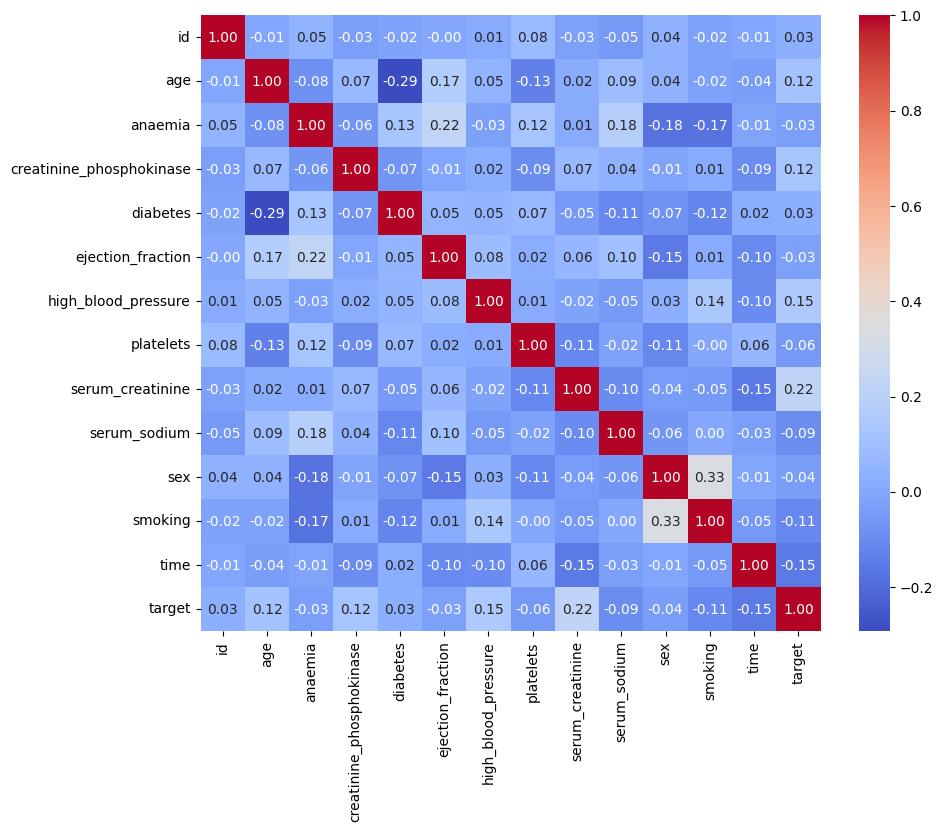

In [4]:
# Calculate the correlation matrix
corr_matrix = train_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [5]:
# Set a correlation threshold 
correlation_threshold = 0.08

# Find features with low correlation to the target variable
correlated_features = corr_matrix.index[abs(corr_matrix['target']) < correlation_threshold]

# Remove these features from the dataset
train_df_reduced = train_df.drop(columns=correlated_features)

# Print the removed features and the number of remaining features
print(f"Removed features with low correlation with the target: {list(correlated_features)}")
print(f"Number of features after removal: {train_df_reduced.shape[1]}")

Removed features with low correlation with the target: ['id', 'anaemia', 'diabetes', 'ejection_fraction', 'platelets', 'sex']
Number of features after removal: 8


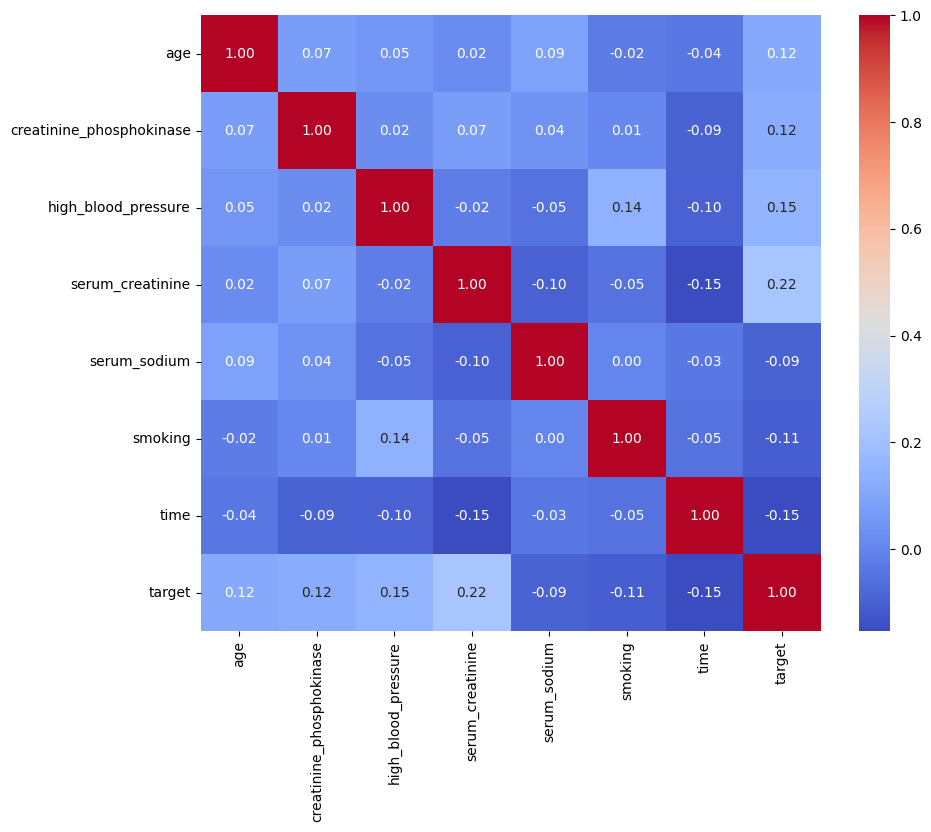

In [6]:
# Calculate the correlation matrix
corr_matrix = train_df_reduced.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [7]:
train_df = train_df_reduced

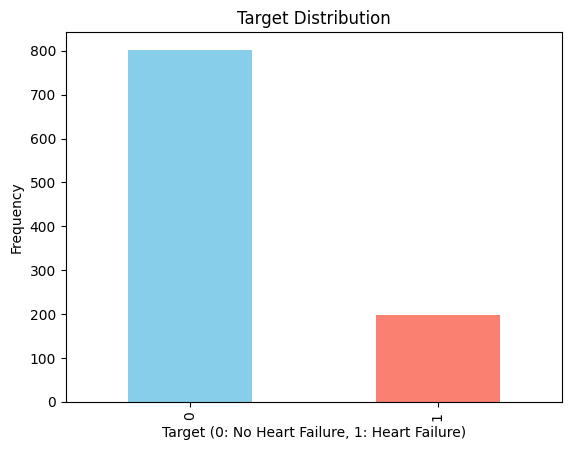

target
0    802
1    198
Name: count, dtype: int64


In [8]:
# Plot the distribution of the target variable
train_df['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution')
plt.ylabel('Frequency')
plt.xlabel('Target (0: No Heart Failure, 1: Heart Failure)')
plt.show()
print(train_df['target'].value_counts())

# The target distribution shows a clear imbalance, with a significant majority of 0's (No Heart Failure).

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [10]:
# Scaling the data (standardization)
# Standardize all numerical features except 'id' and 'target'
scaler = StandardScaler()
numerical_features = train_df.select_dtypes(include=[np.number]).columns

# Exclude 'id' and 'target' from scaling
numerical_features = numerical_features[numerical_features != 'id']
numerical_features = numerical_features[numerical_features != 'target']

# Scale the data
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])

# Balancing the classes
# Check the distribution of the target variable
print(train_df['target'].value_counts())

target
0    802
1    198
Name: count, dtype: int64


In [12]:
# Since class 0 is significantly larger, apply oversampling to class 1 (using resample)
# This is a simple approach for balancing the classes

# Split the data into two classes
class_0 = train_df[train_df['target'] == 0]
class_1 = train_df[train_df['target'] == 1]

# Upsample class 1 to match the size of class 0
class_1_upsampled = resample(class_1, 
                              replace=True,    # Allow repeated selection
                              n_samples=len(class_0),  # To match the size of class 0
                              random_state=42)  # For reproducibility

# Combine the classes back together
train_df_balanced = pd.concat([class_0, class_1_upsampled])

# Shuffle the data to avoid any ordering
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new class distribution
print(train_df_balanced['target'].value_counts())

target
0    802
1    802
Name: count, dtype: int64


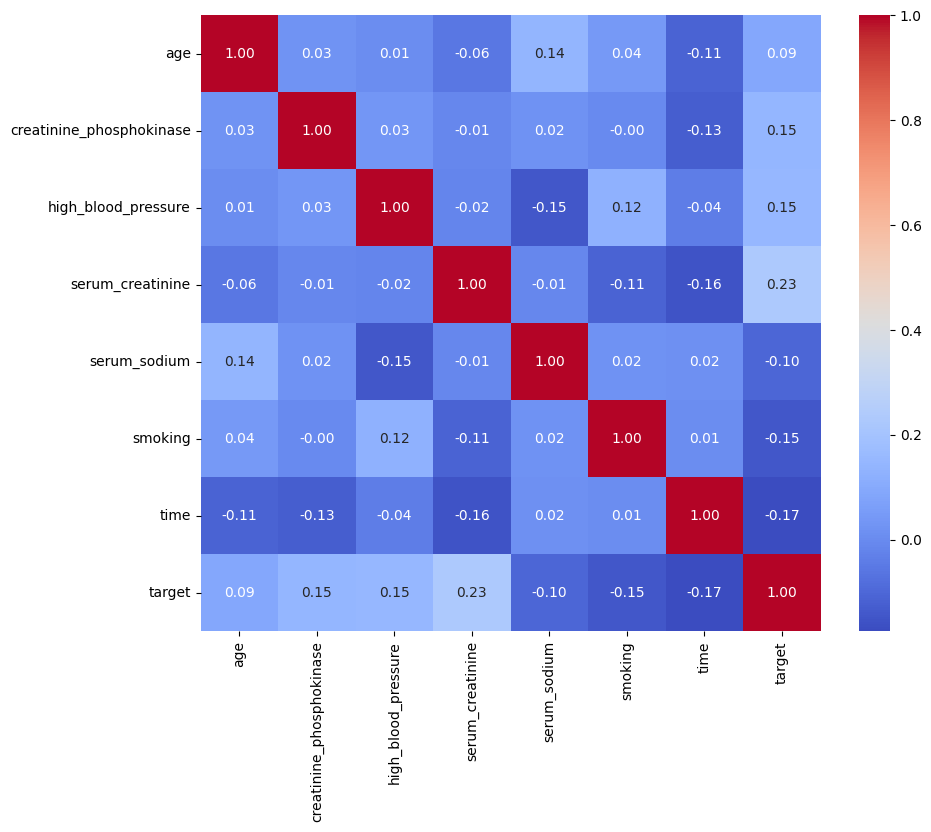

In [51]:
# Calculate the correlation matrix
corr_matrix = train_df_balanced.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [11]:
# Split the data into features and target variable
X = train_df_balanced.drop(columns=['target'])
y = train_df_balanced['target']

# Split the data into training and test sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

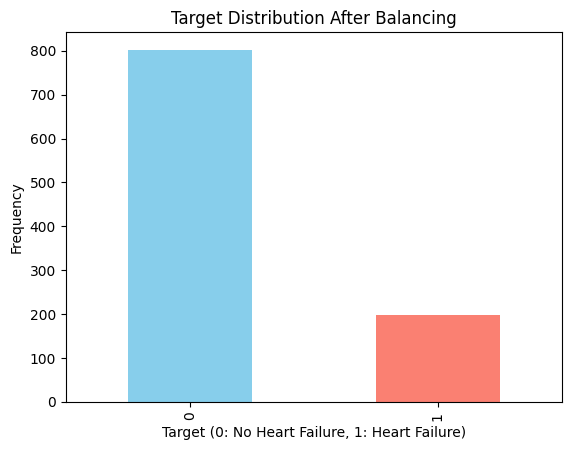

In [12]:
# Visualize the distribution of the target variable after balancing
train_df_balanced['target'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution After Balancing')
plt.ylabel('Frequency')
plt.xlabel('Target (0: No Heart Failure, 1: Heart Failure)')
plt.show()

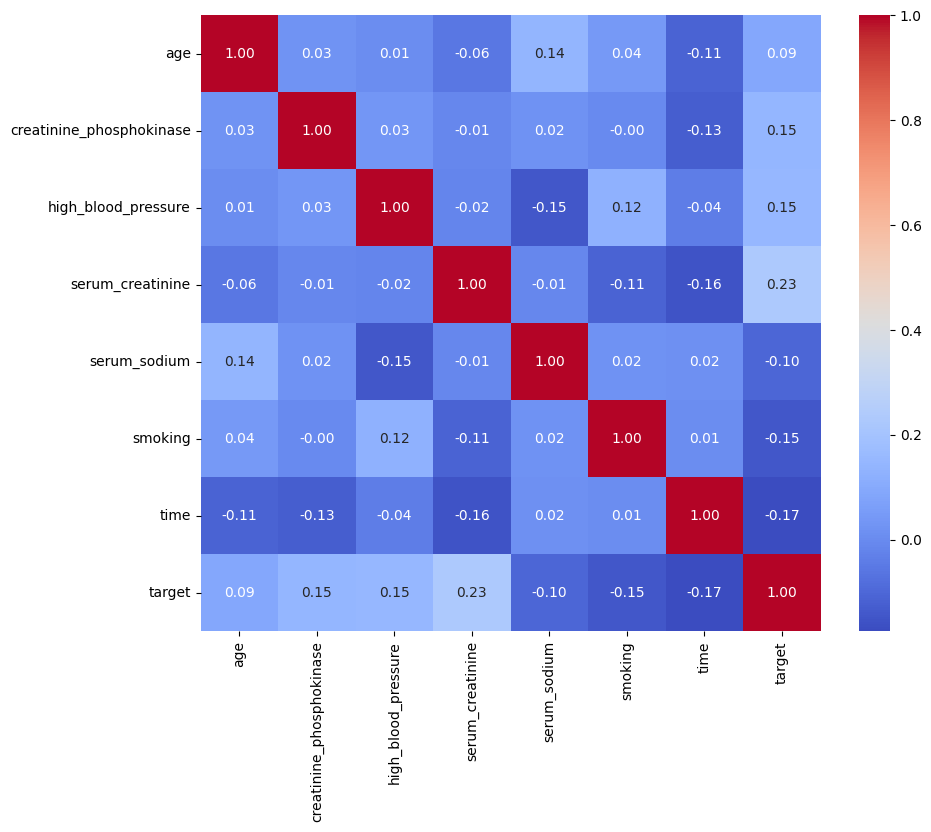

In [16]:
# Calculate the correlation matrix
corr_matrix = train_df_balanced.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [14]:
# 1. Create the logistic regression model
model = LogisticRegression(random_state=42)

# 2. Train the model using the training data
model.fit(X_train, y_train)

# 3. Make predictions on the test data
y_pred = model.predict(X_test)

# 4. Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# 5. Detailed classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 7. Cross-validation to assess model performance
cv_scores = cross_val_score(model, X, y, cv=5)  # 5-fold cross-validation
print(f"\nCross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")

Accuracy: 0.8100

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.99      0.89       162
           1       0.50      0.05      0.10        38

    accuracy                           0.81       200
   macro avg       0.66      0.52      0.49       200
weighted avg       0.76      0.81      0.74       200


Confusion Matrix:
[[160   2]
 [ 36   2]]

Cross-validation scores: [0.805 0.81  0.78  0.81  0.815]
Mean cross-validation score: 0.8040


/Users/user/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/user/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

# 1. Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# 2. Train the model using the training data
rf_model.fit(X_train, y_train)

# 3. Make predictions on the test data
y_pred_rf = rf_model.predict(X_test)

# 4. Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# 5. Detailed classification report (precision, recall, f1-score)
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# 6. Confusion matrix
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# 7. Cross-validation to assess model performance
cv_scores_rf = cross_val_score(rf_model, X, y, cv=5)  # 5-fold cross-validation
print(f"\nRandom Forest Cross-validation scores: {cv_scores_rf}")
print(f"Mean cross-validation score: {cv_scores_rf.mean():.4f}")

Random Forest Accuracy: 0.8850

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       162
           1       0.80      0.53      0.63        38

    accuracy                           0.89       200
   macro avg       0.85      0.75      0.78       200
weighted avg       0.88      0.89      0.88       200


Random Forest Confusion Matrix:
[[157   5]
 [ 18  20]]

Random Forest Cross-validation scores: [0.815 0.865 0.83  0.855 0.845]
Mean cross-validation score: 0.8420


In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
# 1. Create the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# 2. Perform cross-validation (5-fold cross-validation)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='accuracy')  # scoring='accuracy' for classification

# 3. Print cross-validation results
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores):.4f}")
print(f"Standard deviation of cross-validation scores: {np.std(cv_scores):.4f}")


Cross-validation scores: [0.815 0.865 0.83  0.855 0.845]
Mean cross-validation score: 0.8420
Standard deviation of cross-validation scores: 0.0178


In [96]:
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.9 MB/s eta 0:00:0000:0100:01


XGBoost Accuracy: 0.8450

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.93      0.91       162
           1       0.62      0.47      0.54        38

    accuracy                           0.84       200
   macro avg       0.75      0.70      0.72       200
weighted avg       0.83      0.84      0.84       200



/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:03:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


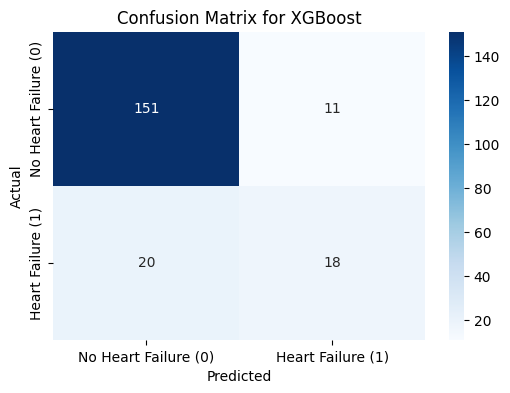

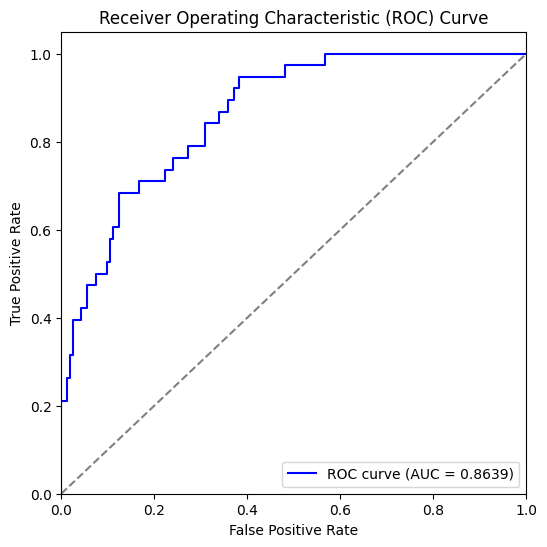

In [17]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc

# 1. Создаем модель XGBoost
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# 2. Обучаем модель на тренировочных данных
xgb_model.fit(X_train, y_train)

# 3. Сделаем предсказания на тестовых данных
y_pred_xgb = xgb_model.predict(X_test)

# 4. Оценка точности
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

# 5. Detailed classification report (precision, recall, f1-score)
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

# 6. Confusion matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['No Heart Failure (0)', 'Heart Failure (1)'], yticklabels=['No Heart Failure (0)', 'Heart Failure (1)'])
plt.title('Confusion Matrix for XGBoost')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 7. ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, xgb_model.predict_proba(X_test)[:,1])  # Using probabilities for positive class
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Stacking model

In [18]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Create base models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
gb_model = GradientBoostingClassifier(random_state=42)

# 2. Create the meta-model (logistic regression)
meta_model = LogisticRegression()

# 3. Create the Stacking model
stacking_model = StackingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('gb', gb_model)],  # Base models
    final_estimator=meta_model,  # Meta-model
)

# 4. Train the ensemble model on the training data
stacking_model.fit(X_train, y_train)

# 5. Make predictions on the test data
y_pred_stacking = stacking_model.predict(X_test)

# 6. Evaluate accuracy
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Model Accuracy: {accuracy_stacking:.4f}")

# 7. Detailed classification report (precision, recall, f1-score)
print("\nStacking Model Classification Report:")
print(classification_report(y_test, y_pred_stacking))


/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [23:03:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bs

Stacking Model Accuracy: 0.8550

Stacking Model Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.91       162
           1       0.70      0.42      0.52        38

    accuracy                           0.85       200
   macro avg       0.79      0.69      0.72       200
weighted avg       0.84      0.85      0.84       200



# Result saving

In [19]:
test_df = pd.read_csv('test.csv')
#test_df[numerical_features] = scaler.transform(test_df[numerical_features])

y_pred_test = stacking_model.predict(test_df.drop(columns=['id', 'anaemia', 'diabetes', 'ejection_fraction', 'platelets', 'sex']))
y_pred_test

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [20]:
submission_df = pd.DataFrame({
    'id': test_df['id'],  
    'target': y_pred_test 
})
submission_df.to_csv('results/naive_stacking_model_v1.csv', header=False, index=False)

In [21]:
# calculating difference with previous submission
submission = pd.read_csv('results/naive_stacking_model_v1.csv', header=None)
submission1 = pd.read_csv('results/submission_drop_low_corr_stacking_v1.csv', header=None)


differences = (submission[1] != submission1[1 ]).sum()

print(f"Number of differing answers: {differences}")


Number of differing answers: 47


# SMOTE for syntetic data

In [26]:
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 7.3 MB/s eta 0:00:00


In [33]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Create base models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
gb_model = GradientBoostingClassifier(random_state=42)

# 2. Create the meta-model (logistic regression)
meta_model = LogisticRegression()

# 3. Create the Stacking model
stacking_model = StackingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model), ('gb', gb_model)],  # Base models
    final_estimator=meta_model,  # Meta-model
)

# 4. Apply SMOTE for balancing classes in the training set

# Split the data into features and target variable
X = train_df.drop(columns=['target'])
y = train_df['target']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split the data into training and test sets (80% for training, 20% for testing)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)



# 5. Train the ensemble model on the resampled (balanced) data
stacking_model.fit(X_resampled, y_resampled)

# 6. Make predictions on the test data
y_pred_stacking = stacking_model.predict(X_test)

# 7. Evaluate accuracy
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Model with SMOTE Accuracy: {accuracy_stacking:.4f}")

# 8. Detailed classification report (precision, recall, f1-score)
print("\nStacking Model with SMOTE Classification Report:")
print(classification_report(y_test, y_pred_stacking))


/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:53:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/user/anaconda3/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:53:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bs

Stacking Model with SMOTE Accuracy: 1.0000

Stacking Model with SMOTE Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00       143

    accuracy                           1.00       321
   macro avg       1.00      1.00      1.00       321
weighted avg       1.00      1.00      1.00       321



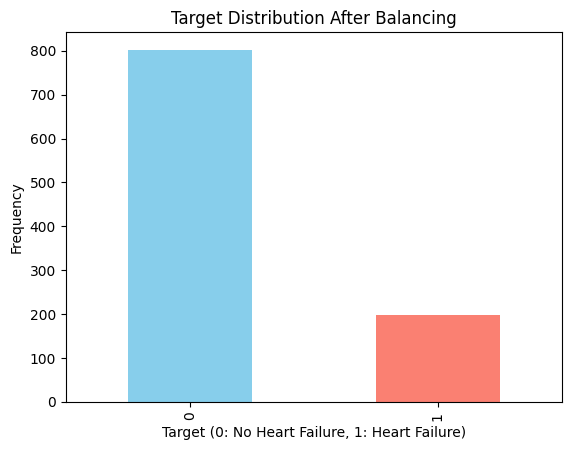

In [57]:
# Visualize the distribution of the target variable after balancing
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Target Distribution After Balancing')
plt.ylabel('Frequency')
plt.xlabel('Target (0: No Heart Failure, 1: Heart Failure)')
plt.show()